In [2]:
history_points = 50
def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path)
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)

    data = data.values

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)

    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)
    technical_indicators = np.array([[0]] * len(technical_indicators))

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser


In [3]:
##SADA

csv_path="MSFT_daily.csv"
data = pd.read_csv(csv_path)
data = data.drop(0, axis=0)
data.columns="date open high low close volume".split()
col='open'
#data[f'{col}_diff1'] = data[col] - data[col].shift(1)
data.dropna(inplace=True)
data

scaler = preprocessing.StandardScaler()
datan  = scaler.fit_transform(data[data.columns[1:]])
#scaler = preprocessing.MinMaxScaler()
#datan  = scaler.fit_transform(data[data.columns[1:]])

datan.shape

(5032, 5)

In [4]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = \
                    csv_to_dataset('MSFT_daily.csv')
ohlcv_histories.shape, next_day_open_values.shape, next_day_open_values.shape

((4982, 50, 5), (4982, 1), (4982, 1))

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator
history_points = 50

tsParams = {'length': history_points, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1}
X = datan
y = datan[:,0]
y = y.reshape(-1,1)
nl = X.shape[0]
n = int(len(X) * .9)

trng    = TimeseriesGenerator(X[:n], y[:n], **tsParams )
valg    = TimeseriesGenerator(X[n:], y[n:], **tsParams )
technical_indicators = np.array([[0]] * len(trng))
n, len(trng),n, datan.shape, trng[0][0].shape

(4528, 4478, 4528, (5032, 5), (1, 50, 5))

In [8]:
test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(n, ohlcv_histories.shape, ohlcv_train.shape, ohlcv_test.shape)


4483 (4982, 50, 5) (4483, 50, 5) (499, 50, 5)


In [9]:
xx= np.array([trng[i][0][0] for i in range(len(trng))])
technical_indicators = np.array([[0]] * len(xx))

yy = np.array([trng[i][1][0] for i in range(len(trng))])
xx.shape, technical_indicators.shape, yy.shape

((4478, 50, 5), (4478, 1), (4478, 1))

In [10]:
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
#model = Model(inputs=lstm_branch.input, outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')


In [21]:
model.fit([xx[:n], technical_indicators[:n]], y=yy[:n], epochs=20, shuffle=True, validation_split=0.1)

# evaluation
'''
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)
''';

Train on 4030 samples, validate on 448 samples
Epoch 1/20
4030/4030 [==============================] - 2s 461us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 2/20
4030/4030 [==============================] - 2s 466us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/20
4030/4030 [==============================] - 2s 472us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4/20
4030/4030 [==============================] - 2s 464us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/20
4030/4030 [==============================] - 2s 462us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 6/20
4030/4030 [==============================] - 2s 464us/step - loss: 0.0023 - val_loss: 0.0033
Epoch 7/20
4030/4030 [==============================] - 2s 460us/step - loss: 0.0022 - val_loss: 0.0039
Epoch 8/20
4030/4030 [==============================] - 2s 465us/step - loss: 0.0021 - val_loss: 0.0032
Epoch 9/20
4030/4030 [==============================] - 2s 464us/step - loss: 0.0021 - val_loss: 8.5903e-04
Epoch 10/20
4

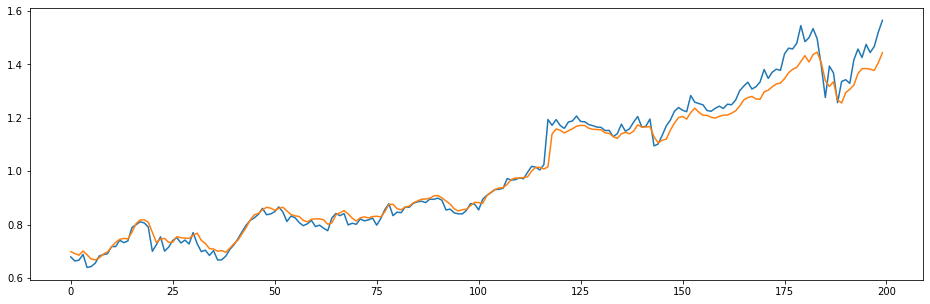

In [22]:
pn=-200
xt= xx[pn:]
technical_indicators_t = np.array([[0]] * len(xt))

yt = yy[pn:]
xt.shape, technical_indicators_t.shape, yt.shape
yh = model.predict([xt, technical_indicators_t])
plt.plot(yt)
plt.plot(yh)

In [ ]:
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)

output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
#model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
model.fit(xx[:n], y=yy[:n], epochs=4, shuffle=True, validation_split=0.1)


In [ ]:
model.fit(xx[:n], y=yy[:n], epochs=10, shuffle=True, validation_split=0.1)

In [ ]:
model.fit(trng, verbose=1, epochs=1, validation_data=None,steps_per_epoch=200,
                   validation_steps=50)

xt= xx[n:]

yt = yy[n:]
xt.shape, technical_indicators_t.shape, yt.shape
yh = model.predict(xt)
plt.plot(yt)
plt.plot(yh)

In [ ]:
yy.shape, xx.shape

In [ ]:
from keras.layers import RepeatVector, TimeDistributed
model1=None      

#sensN = len(self.train_transformed[0].columns)  # number of sensors (eliminating the two time ones)
#outN = len(self.num_id_list) # number of output sensors; the non-categorical ones        

lookBack   = tsParams['length']
nFeatures  = xx.shape[2]  # Number of features 
lstm_OPDim = yy.shape[1]  # This is usually all sensors except categorical that to train LSTM on
lstm_IPDim = 256
drop       = 0.3
optimizer  = optimizers.Adam(lr=0.0005)
loss       = 'mse'
k_rrizer   = None
r_rrizer   = None

input_layer  = Input(shape=(lookBack, nFeatures), dtype='float32', name='input')
memory_layer = LSTM( lstm_IPDim, return_sequences=True, name="memory1")(input_layer)
memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=False, name="memory2")(memory_layer)
repeated = RepeatVector(lookBack)(memory_layer)
memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=True, name="first1out")(repeated)
memory_layer = LSTM (lstm_IPDim,  return_sequences=True, name="first2out")(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=lstm_OPDim, activation='linear'))( memory_layer)

#  Try spatial dropout?
dropout_input = Dropout(drop)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])

#memory_layer = LSTM (units=self.lstm_dim, return_sequences=False)(concat_layer)
memory_layer = LSTM (units=lstm_IPDim, 
                         kernel_regularizer = k_rrizer, 
                         recurrent_regularizer = r_rrizer, 
                         return_sequences=False)(concat_layer)
preds = Dense(units=lstm_OPDim, activation='linear')(memory_layer)

model1 = Model(input_layer, preds)
model1.compile(optimizer = optimizer, loss= loss)             

print(model1.summary())


In [ ]:
model1.fit(trng, verbose=1, epochs=1, validation_data=None,steps_per_epoch=200,
                   validation_steps=50)

xt= xx[n:]

yt = yy[n:]
yh = model1.predict(xt)
plt.plot(yt)
plt.plot(yh)